数据的描述性统计：要对模型标准化残差和残差的平方进行LB检验、LM检验arch。之后分别把所有copula模型都带进去试一下，用LLF选出最好的那个（先只考虑下尾 常用的有五个clayton、rotated joe、rotated gumbel、rotated gamambos、rotated H、、）

选出最好的copula之后，选取分位数点5%估计CQR模型，进而得到下行风险溢出，和正常市场情况时的对比进行KS显著性检验（结果需要说明下行covar和市场处于基准状态时有很大差异），之后给出下行风险溢出的描述性统计数据。（排序 各个均值 sd和max），再画一个covar和delta covar的动态图。

In [27]:
#install.packages('FinTS')
#install.packages('GGally')
#install.packages("ggplotify")
#install.packages("ggpubr")
install.packages('mistr')
library(rugarch)
library(VineCopula)
library(fGarch) 
library(quantreg)
library(readxl)
library(xts)
library(ggplot2)
library(tidyr)
library(moments)
library(tseries)
library(FinTS)
library(GGally)
library(gridExtra)
library(ggplotify)
library(ggpubr)
library(grid)
library(mistr)

package 'mistr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\88464\AppData\Local\Temp\RtmpeoFiTQ\downloaded_packages


Warning message:
"package 'mistr' was built under R version 4.2.3"

Attaching package: 'mistr'


The following object is masked from 'package:base':

    q




In [4]:
data<- read_excel("C:\\Users\\88464\\Desktop\\origin_ts_data.xlsx")
data$日期 <- as.Date(data$日期, format = "%Y-%m-%d")

##画出原始变量的趋势图

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


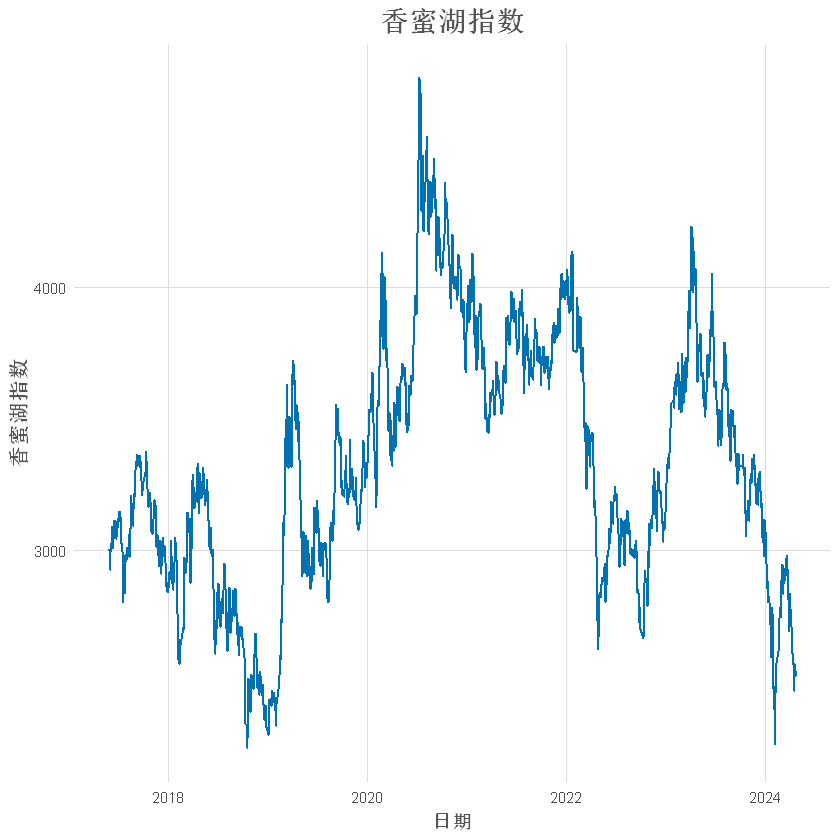

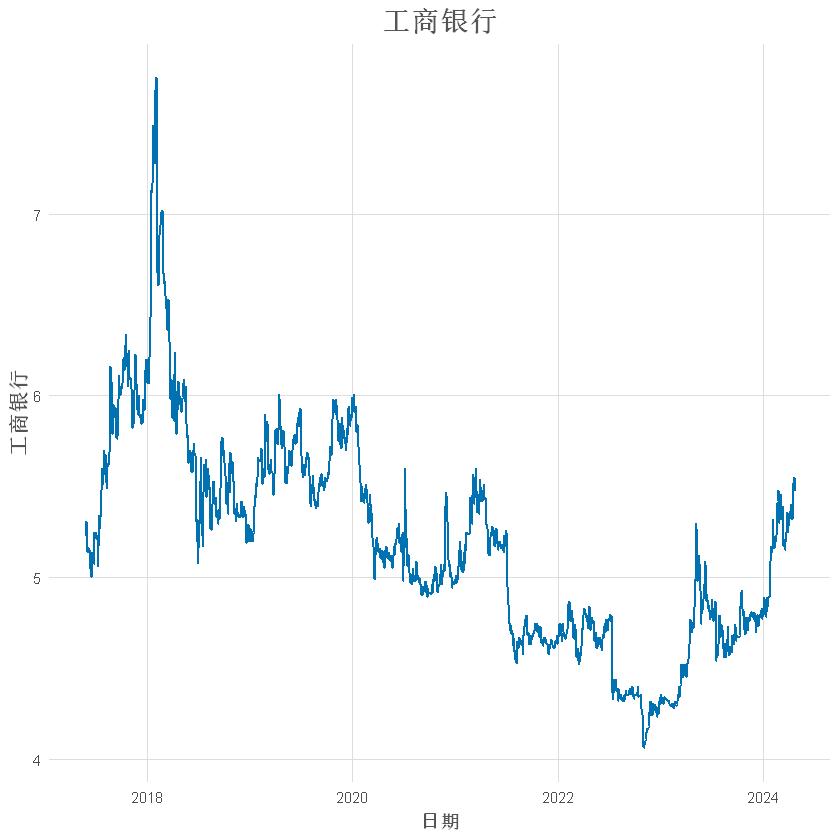

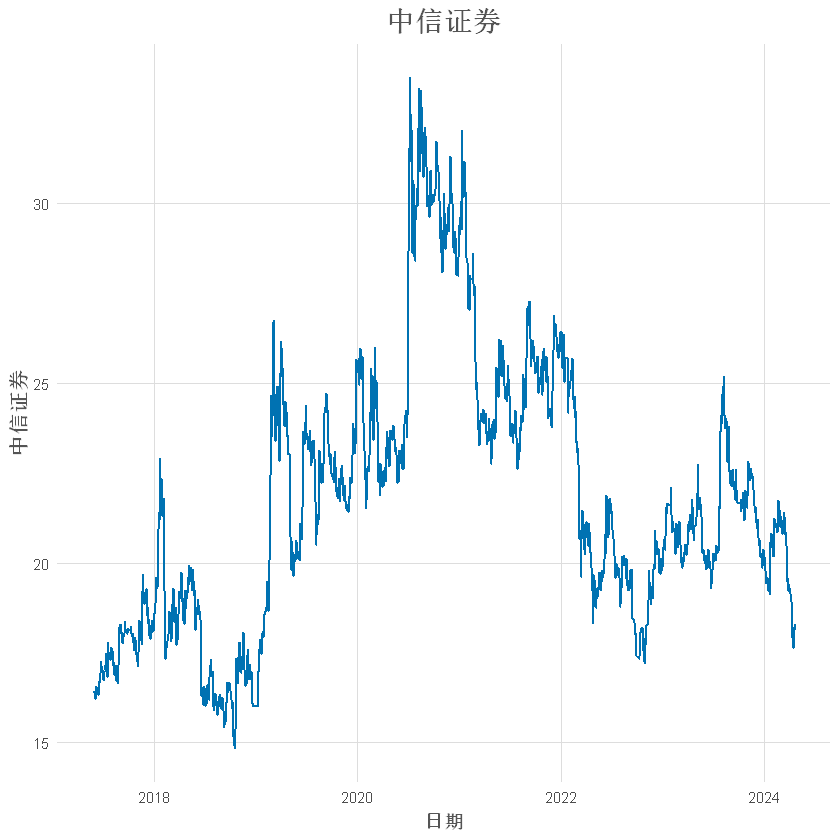

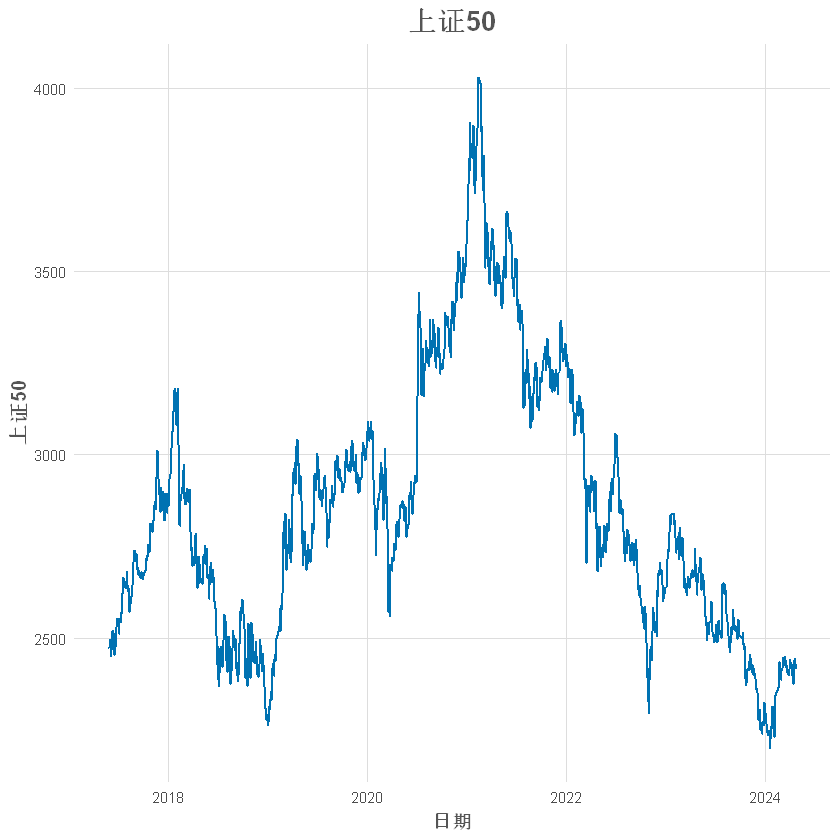

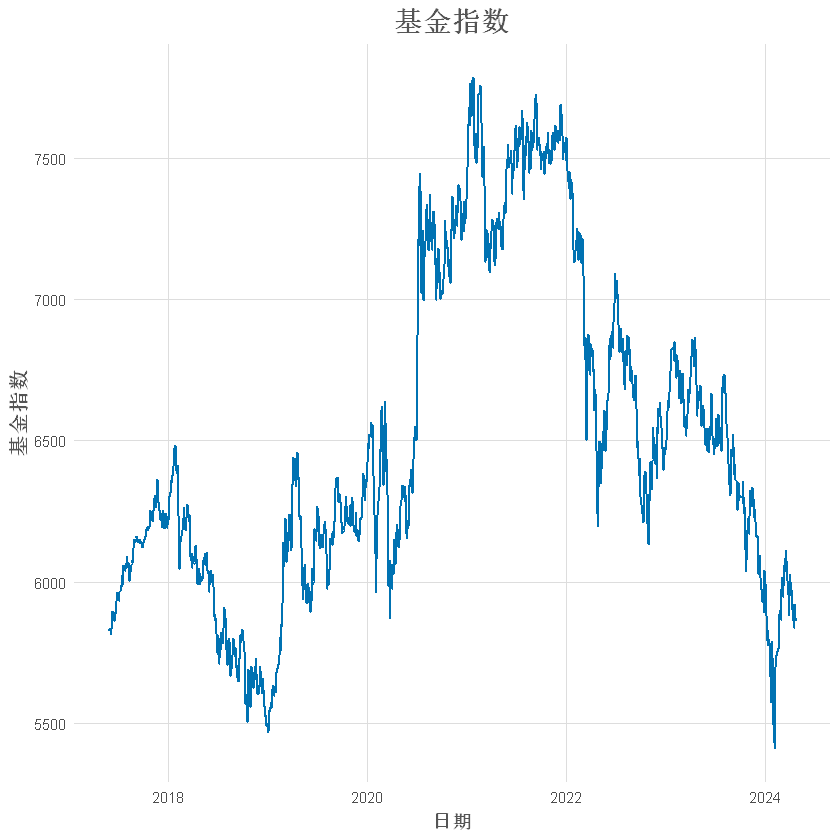

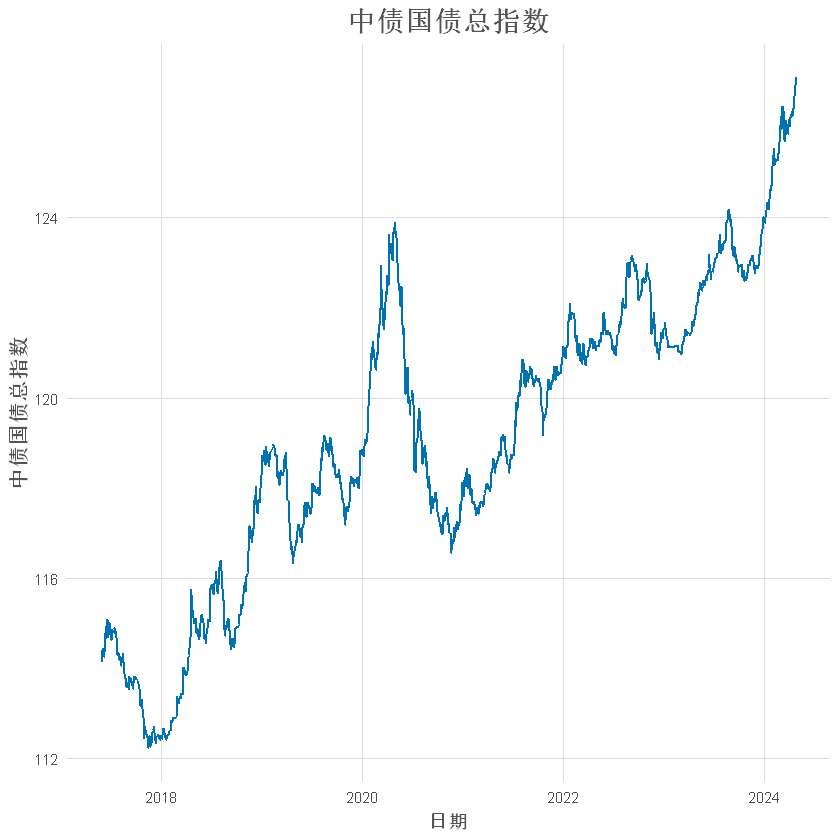

In [5]:

variable_names <- colnames(data)[-which(colnames(data) == "日期")]

for (variable in variable_names) {
  current_data <- data[c("日期", variable)]
  
  p <- ggplot(current_data, aes(x = 日期, y = !!sym(variable))) +
    geom_line(color = "#0072B2", size = 0.8) + 
    labs(
      x = "日期", 
      y = variable, 
      title = paste(variable),
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, color = "#555555", size = 16, face = "bold"),  # 调整标题样式
      axis.title.x = element_text(face = "bold", color = "#555555", size = 12),
      axis.title.y = element_text(face = "bold", color = "#555555", size = 12),
      panel.grid.major = element_line(color = "#DDDDDD"),
      panel.grid.minor = element_blank(),
      legend.position = "none"
    )
  
  print(p)
}


In [12]:
df <- read_excel("C:\\Users\\88464\\Desktop\\ts_data.xlsx")
df$日期 <- as.Date(df$日期, format = "%Y-%m-%d")
# 调整为日期格式
ts_df <- xts(df[-1], order.by = df$日期)
date_st <- index(ts_df)
dim(ts_df)
tail(ts_df)

[1] 1678    6

           香蜜湖指数   工商银行     基金指数     上证50    中信证券
2024-04-16 -4.0291639  0.9182801 -0.549962451 -0.4838379 -0.62199805
2024-04-17  4.2765524  0.5469476 -0.284285204  1.1351721  2.63099419
2024-04-18 -0.3160644  0.3629768  0.249136693  0.2186259  0.60589555
2024-04-19 -1.6792034  0.5420067  0.098898668 -0.5997007 -0.44028690
2024-04-22  0.3443545 -1.2692827 -0.002398464 -0.2401486  0.82395413
2024-04-23  0.5518959  0.3642991 -0.099072532 -0.4551014 -0.05471956
           中债国债总指数
2024-04-16     0.02372761
2024-04-17     0.07114906
2024-04-18     0.11846939
2024-04-19     0.09467456
2024-04-22     0.10246306
2024-04-23     0.13383194

##对数收益率

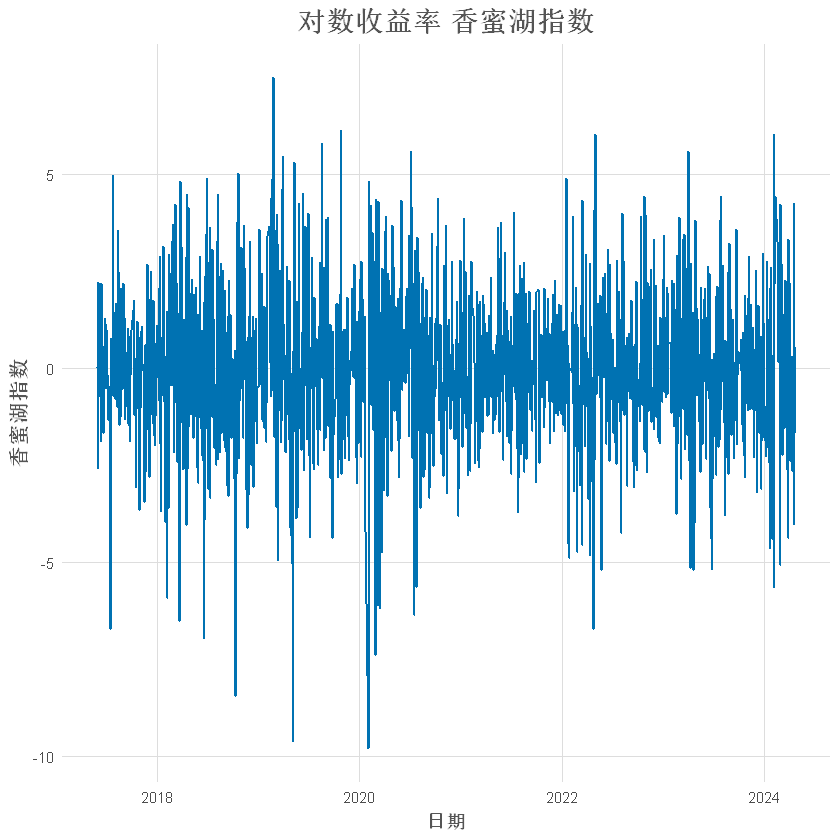

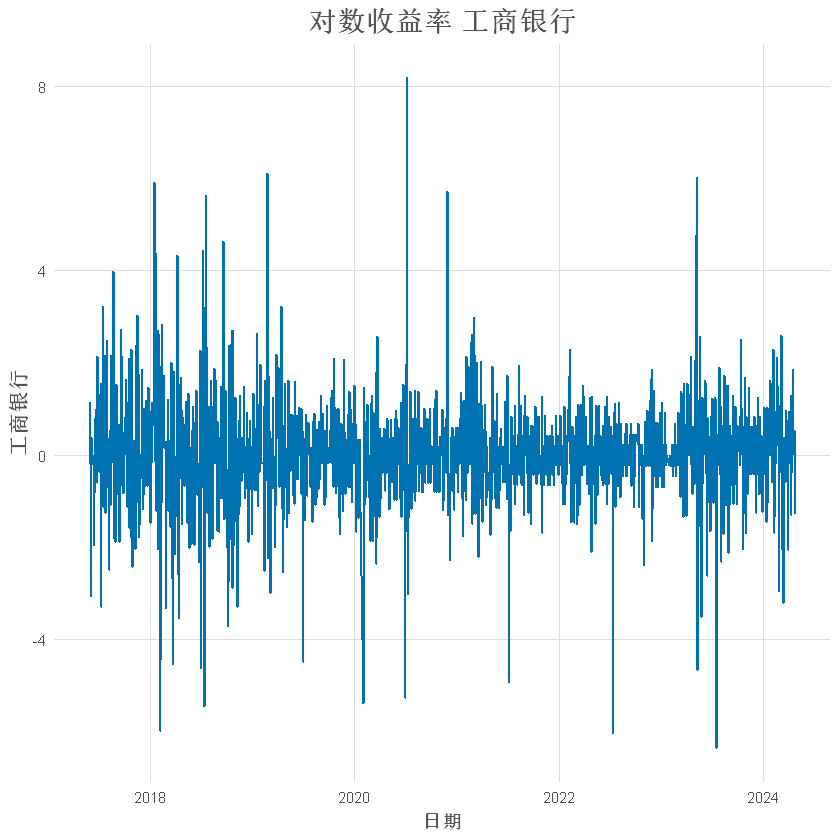

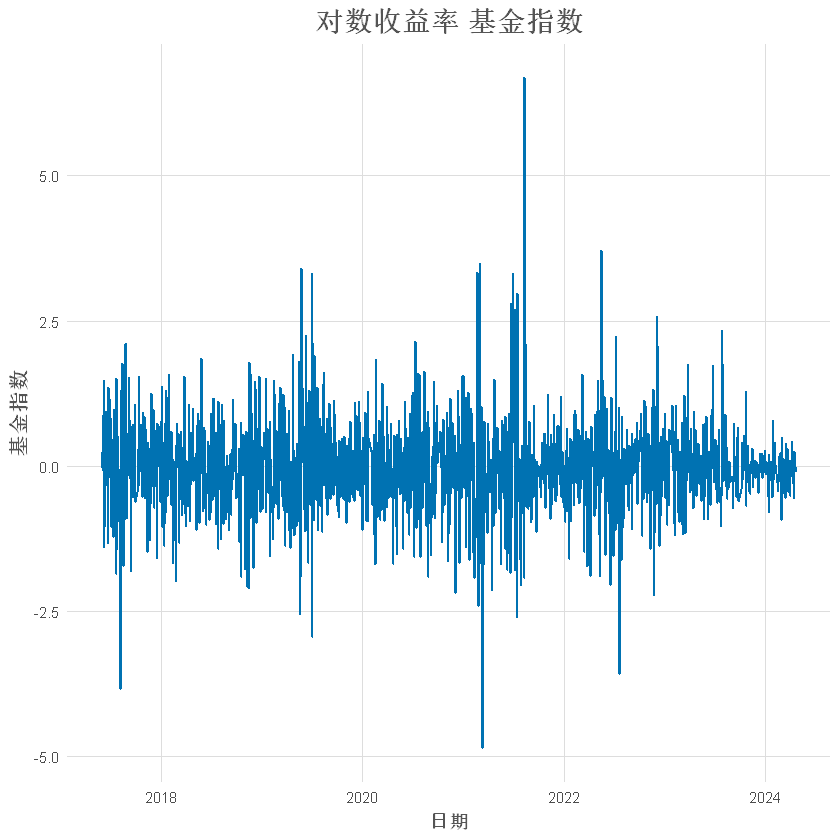

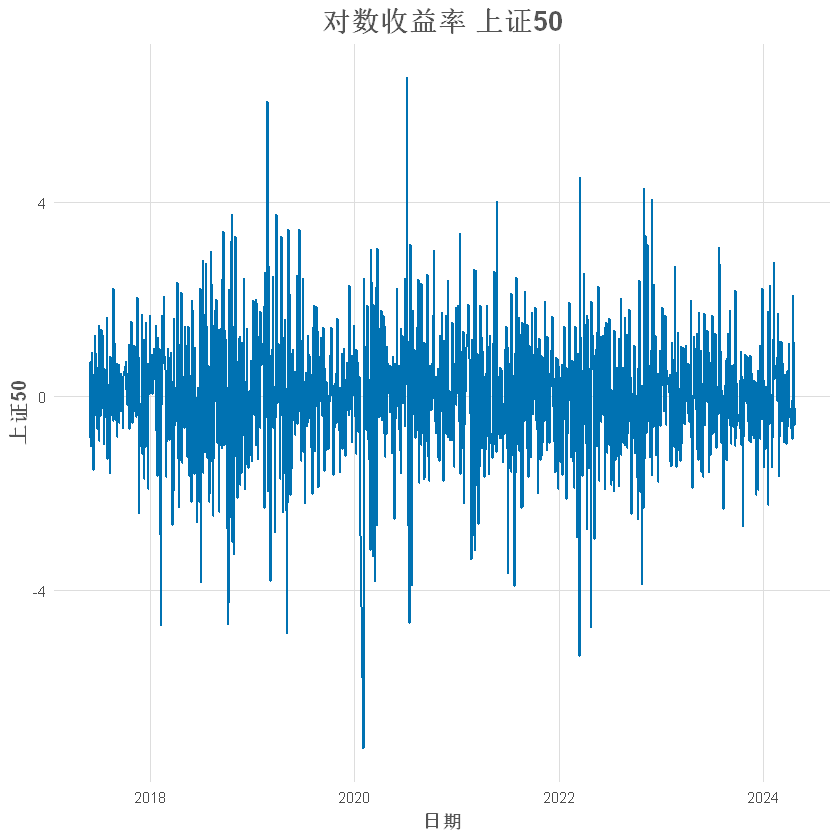

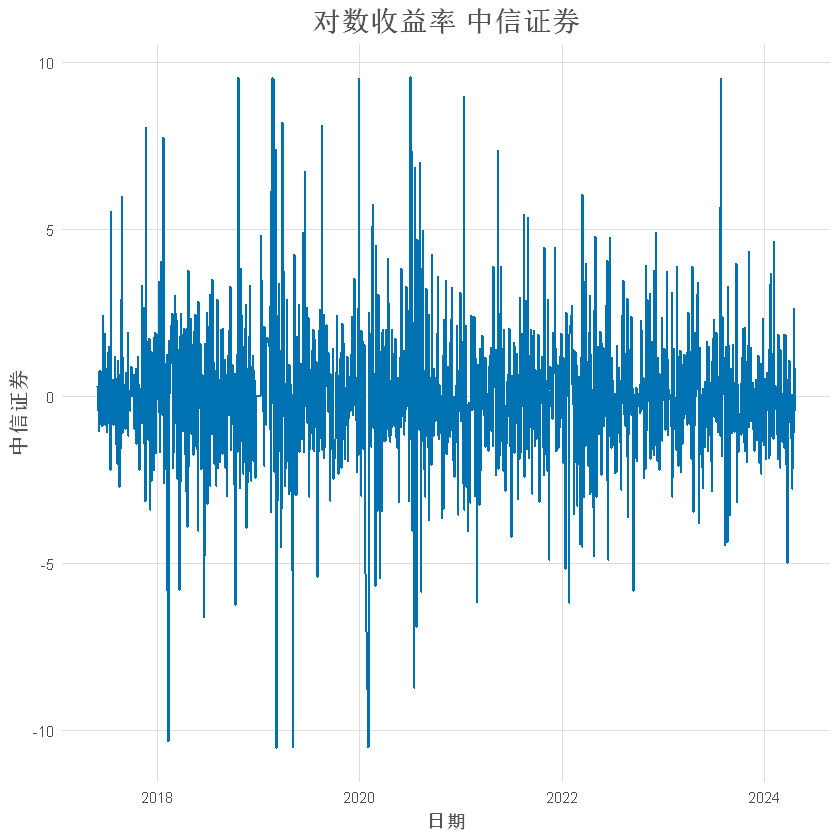

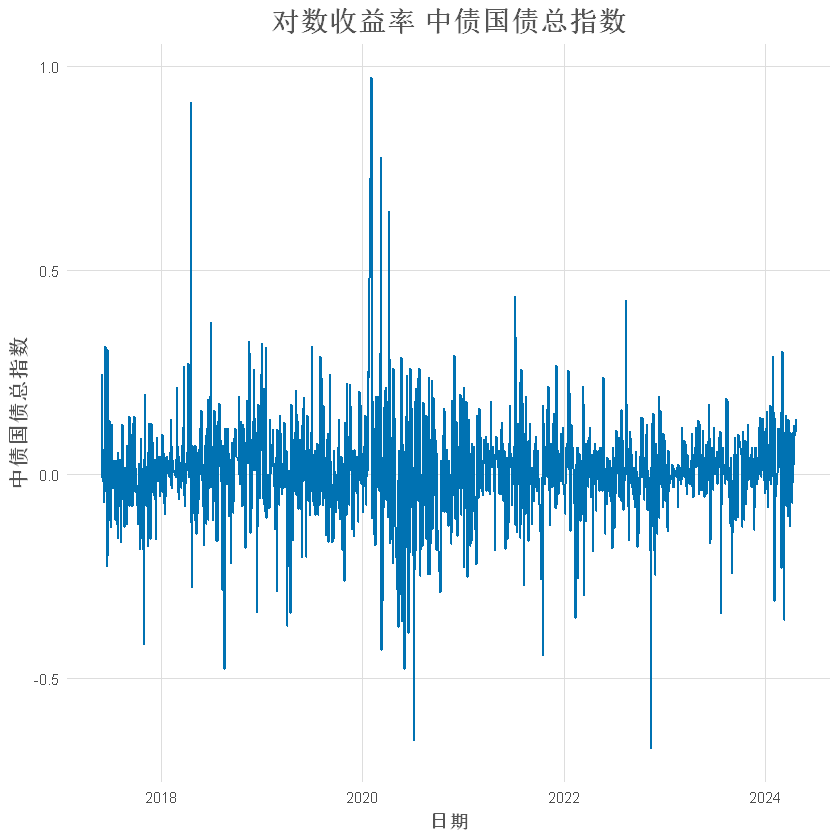

In [7]:
log_data <- colnames(df)[-1]

# 循环遍历每一个变量名
for (variable in log_data) {
  p <- ggplot(df, aes(x = 日期, y = !!sym(variable))) +
    geom_line(color = "#0072B2", size = 0.8) + 
    labs(
      x = "日期", 
      y =  variable, 
      title = paste( '对数收益率',variable)
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, color = "#555555", size = 16, face = "bold"),
      axis.title.x = element_text(face = "bold", color = "#555555", size = 12),
      axis.title.y = element_text(face = "bold", color = "#555555", size = 12),
      panel.grid.major = element_line(color = "#DDDDDD"),
      panel.grid.minor = element_blank(),
      legend.position = "none"
    )
  
  print(p)
}


##时间序列建模前的描述性统计（适合进一步建时间序列模型）

In [8]:

stats <- data.frame(
  Median = apply(ts_df, 2, median, na.rm = TRUE),
  Max = apply(ts_df, 2, max, na.rm = TRUE),
  Min = apply(ts_df, 2, min, na.rm = TRUE),
  StdDev = apply(ts_df, 2, sd, na.rm = TRUE),
  Skewness = apply(ts_df, 2, skewness, na.rm = TRUE),
  Kurtosis = apply(ts_df, 2, kurtosis, na.rm = TRUE)
)
print(stats)


                     Median       Max         Min    StdDev    Skewness
香蜜湖指数     -0.035582761 7.5069444  -9.7974926 1.9049984 -0.18531481
工商银行        0.000000000 8.1830018  -6.3580732 1.1494780  0.09004365
基金指数        0.009672448 6.6864163  -4.8573541 0.7849274  0.34936379
上证50         -0.002884543 6.5834308  -7.2616785 1.1993421 -0.12020979
中信证券       -0.047676076 9.5449708 -10.5526615 1.9865896  0.37146930
中债国债总指数  0.008429576 0.9717281  -0.6723541 0.1147470  0.41826515
                Kurtosis
香蜜湖指数      4.780378
工商银行        9.626870
基金指数        8.924402
上证50          6.028800
中信证券        8.233389
中债国债总指数 12.069147


In [9]:

results <- lapply(ts_df, function(column) {
  if (is.numeric(column)) {
    list(
      JarqueBera = jarque.bera.test(column),
      ArchTest = ArchTest(column),
      ADFTest = adf.test(column)
    )
  }
})
print(results)


Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"


$香蜜湖指数
$香蜜湖指数$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 231.22, df = 2, p-value < 2.2e-16


$香蜜湖指数$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 57.625, df = 12, p-value = 6.095e-08


$香蜜湖指数$ADFTest

	Augmented Dickey-Fuller Test

data:  column
Dickey-Fuller = -11.395, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



$工商银行
$工商银行$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 3072.7, df = 2, p-value < 2.2e-16


$工商银行$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 105.43, df = 12, p-value < 2.2e-16


$工商银行$ADFTest

	Augmented Dickey-Fuller Test

data:  column
Dickey-Fuller = -12.126, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



$基金指数
$基金指数$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 2488.1, df = 2, p-value < 2.2e-16


$基金指数$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 71.472, df = 12, p

结果解释：JB检验用来测试数据正态性，此处p值远小于常见的显著性水平，拒绝原假设，认为收益率数据不符合正态分布。LM检验用于检测异方差性，即时间序列存在条件异方差性，有强烈的波动率集群效应，有ARCH效应应用GARCH模型建模。ADF检验结果表明所有序列都是平稳的。综合来看能够进一步建立时间序列模型分析。

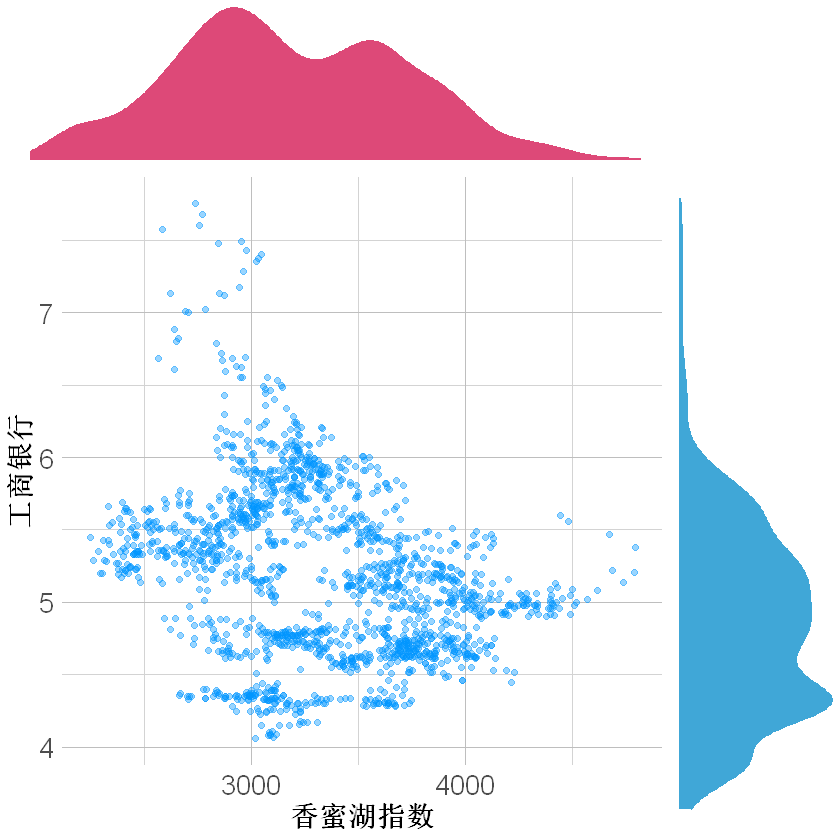

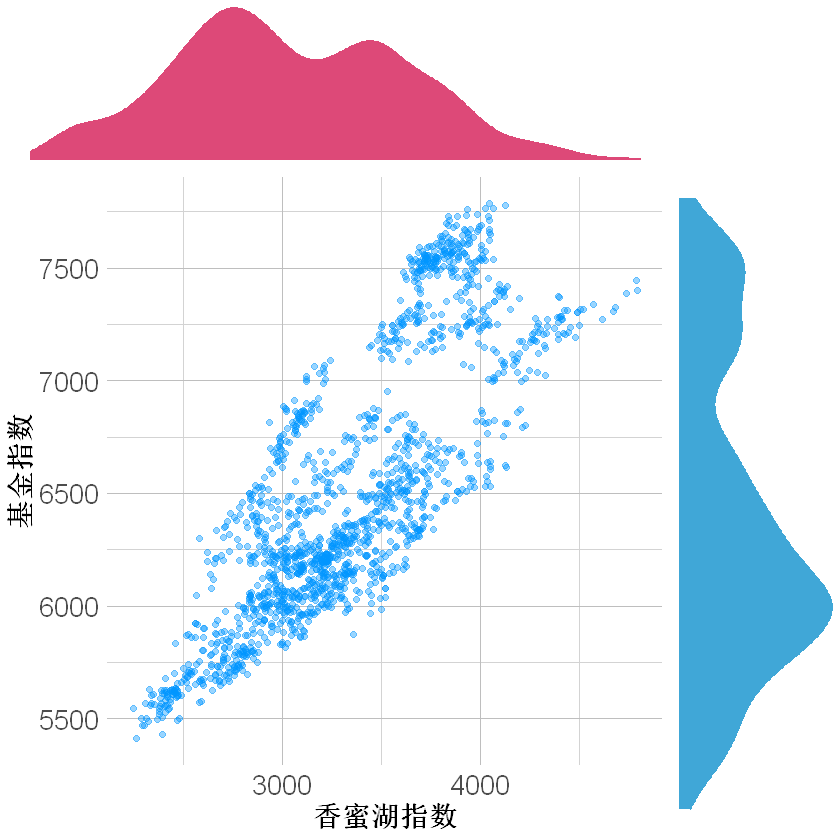

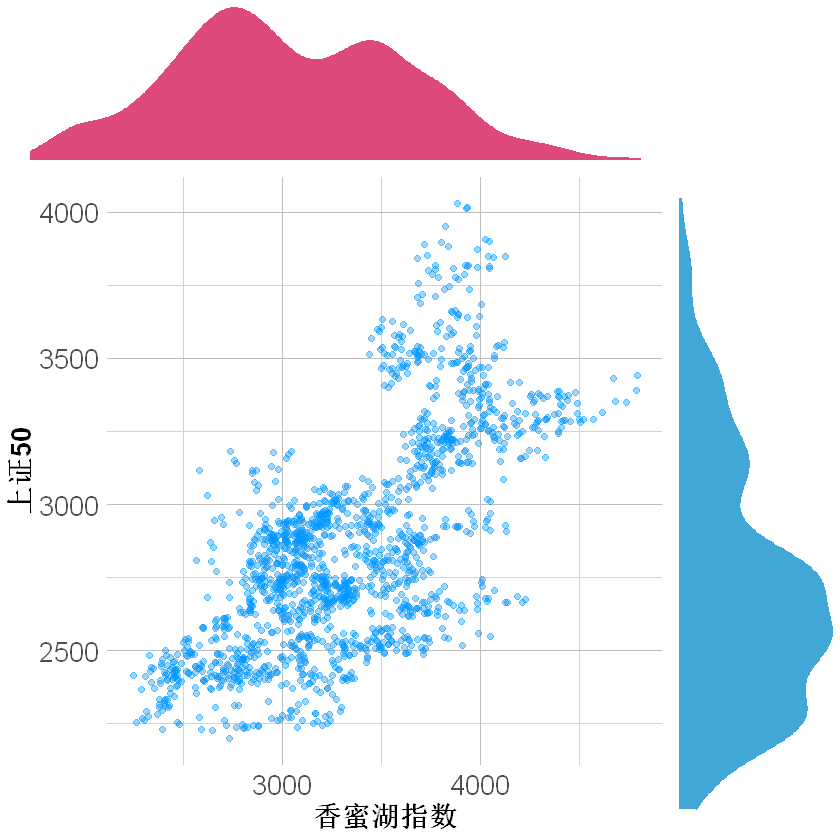

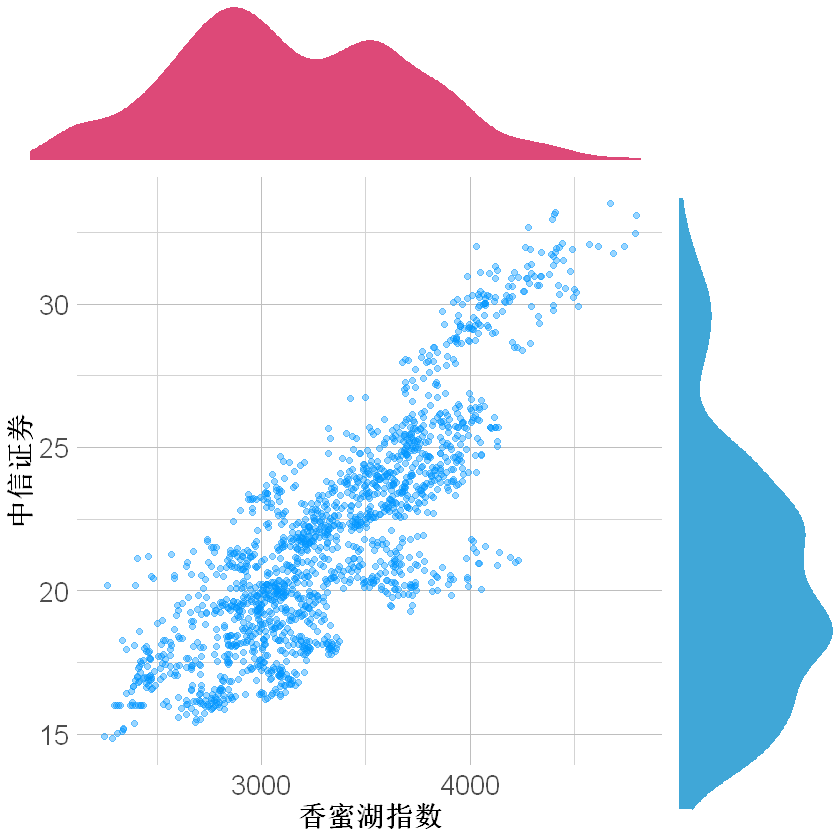

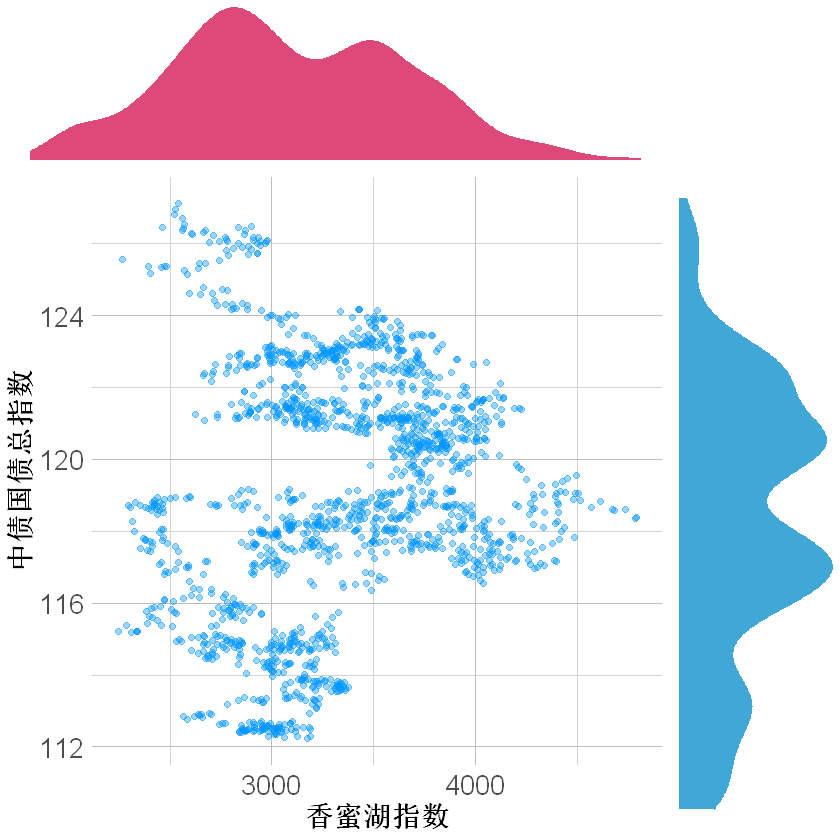

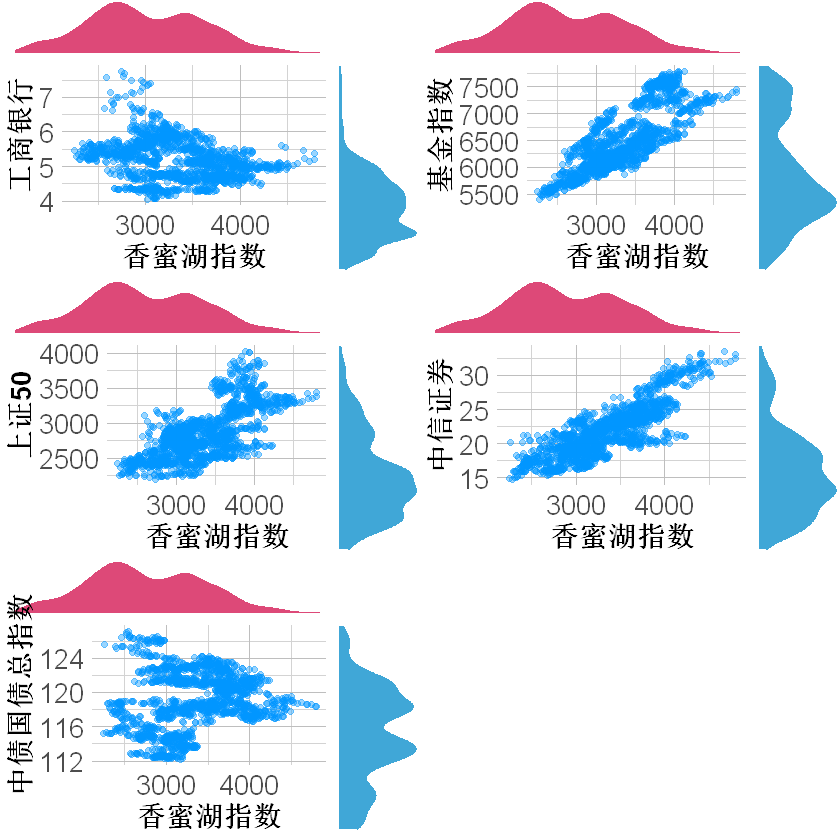

In [24]:
plot_with_marginal_density <- function(data, x_var, y_var) {
  # 使用整洁评估方式处理变量
  x_var_sym <- sym(x_var)
  y_var_sym <- sym(y_var)

  # 主散点图
  main_plot <- ggplot(data, aes(x = !!x_var_sym, y = !!y_var_sym)) +
    geom_point(alpha = 0.4, color = "#0095ff") +
    theme_minimal() +
    theme(panel.grid.major = element_line(color = "gray", linewidth = 0.5),
          panel.grid.minor = element_line(color = "lightgray", linewidth = 0.25),
          text = element_text(size = 16),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 16, face = "bold"),
          plot.title = element_text(size = 16, hjust = 0.5))

  # X变量的密度图
  top_density <- ggplot(data, aes(x = !!x_var_sym)) +
    geom_density(fill = "#dd4978", color = "#dd4978") +
    theme_void()

  # Y变量的密度图
  right_density <- ggplot(data, aes(x = !!y_var_sym)) +
    geom_density(fill = "#40a7d7", color = "#40a7d7") +
    theme_void() +
    coord_flip()

  # 组合图形
  combined_plot <- grid.arrange(
    top_density, nullGrob(),
    main_plot, right_density,
    ncol = 2, nrow = 2,
    widths = c(4, 1), heights = c(1, 4),
    layout_matrix = matrix(c(1, 2, 3, 4), 2, 2, byrow = TRUE)
  )
  
  return(combined_plot)
}
# 应用函数绘制图形
variables <- c('工商银行', '基金指数', '上证50', '中信证券', '中债国债总指数')
plots <- lapply(variables, function(var) {
  plot_with_marginal_density(data, "香蜜湖指数", var)
})

# 显示图形
do.call(grid.arrange, c(plots, ncol = 2))

粗略可以看出香蜜湖指数和证券基金股票和银行市场都有明显的正相关关系 图中还可以直观看出上尾下尾存在非线性关系 应该用非线性模型来研究风险溢出

##对比arma（1，2）-garch（1，1），arma（1，2）-egarch（1，1）和三种分布的LLF和AIC

In [19]:
#ARMA(1,2)-egarch(1,1) model（sstd）
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f1 <- function(x) {ugarchfit(uspec, data = x)}
fit <- apply(ts_df,2, f1)

In [20]:
fit

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.023925    0.021797   -1.0976 0.272364
ar1    -0.402263    0.054178   -7.4249 0.000000
ma1     0.385777    0.054390    7.0928 0.000000
ma2     0.022511    0.015336    1.4679 0.142142
omega   0.047997    0.004089   11.7378 0.000000
alpha1 -0.039948    0.015851   -2.5202 0.011729
beta1   0.962088    0.000120 8015.9724 0.000000
gamma1  0.145880    0.003505   41.6248 0.000000
skew    1.018411    0.031796   32.0293 0.000000
shape   6.603911    1.072243    6.1590 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.023925    0.011298   -2.1176 0.034212
ar1    -0.402263    0.010630  -37.8

In [14]:
#ARMA(1,2)-egarch(1,1) model（std）
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
distribution.model = "std")
#用刚刚定义的模型拟合各列数据
f1_1 <- function(x) {ugarchfit(uspec, data = x)}
fit_1 <- apply(ts_df,2, f1_1)

In [15]:
fit_1

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu     -0.031767    0.041900    -0.75815 0.448362
ar1    -0.407631    0.082958    -4.91369 0.000001
ma1     0.390623    0.083146     4.69807 0.000003
ma2     0.021771    0.024662     0.88278 0.377357
omega   0.048857    0.004228    11.55532 0.000000
alpha1 -0.041005    0.016080    -2.55014 0.010768
beta1   0.961549    0.000063 15375.68412 0.000000
gamma1  0.147376    0.003676    40.09207 0.000000
shape   6.648771    1.084799     6.12904 0.000000

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu     -0.031767    0.042507    -0.74733 0.454866
ar1    -0.407631    0.014142   -28.82421 0.000000
ma1     0.

In [16]:
#ARMA(1,2)-egarch(1,1) model（norm）
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
distribution.model = "norm")
#用刚刚定义的模型拟合各列数据
f1_2 <- function(x) {ugarchfit(uspec, data = x)}
fit_2 <- apply(ts_df,2, f1_2)

In [17]:
fit_2

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.029143    0.045243 -0.64414 0.519482
ar1    -0.259327    0.145561 -1.78157 0.074819
ma1     0.259971    0.145879  1.78209 0.074734
ma2     0.036712    0.025750  1.42572 0.153949
omega   0.077743    0.035582  2.18490 0.028896
alpha1 -0.058137    0.022753 -2.55511 0.010615
beta1   0.942599    0.027963 33.70849 0.000000
gamma1  0.167623    0.030533  5.48987 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.029143    0.049661 -0.58685 0.557305
ar1    -0.259327    0.034599 -7.49530 0.000000
ma1     0.259971    0.036654  7.09254 0.000000
ma2     0.036712    0.024173  1.51873 0.128831
o

In [18]:
#ARMA(1,2)-garch(1,1) model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f2 <- function(x) {ugarchfit(uspec, data = x)}
fit2 <- apply(ts_df,2, f2)

In [19]:
fit2

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.007353    0.043471 -0.16915 0.865681
ar1    -0.376335    0.412649 -0.91200 0.361771
ma1     0.359781    0.412024  0.87320 0.382552
ma2     0.024589    0.027864  0.88248 0.377520
omega   0.104244    0.042514  2.45198 0.014207
alpha1  0.054203    0.012409  4.36804 0.000013
beta1   0.918944    0.019527 47.06112 0.000000
skew    1.023204    0.033488 30.55452 0.000000
shape   6.400032    1.016258  6.29764 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.007353    0.040730 -0.18053  0.85673
ar1    -0.376335    0.258108 -1.45805  0.14483
ma1     0.359781    0.257364  1.39795  0.16213
m

In [20]:
#ARMA(1,2)-garch(1,1) model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
distribution.model = "std")
#用刚刚定义的模型拟合各列数据
f2_1 <- function(x) {ugarchfit(uspec, data = x)}
fit2_1 <- apply(ts_df,2, f2_1)

In [21]:
fit2_1

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.017396    0.040979 -0.42452 0.671187
ar1    -0.388311    0.426515 -0.91043 0.362598
ma1     0.370761    0.425958  0.87042 0.384073
ma2     0.022650    0.028117  0.80557 0.420488
omega   0.105095    0.042701  2.46115 0.013849
alpha1  0.054725    0.012440  4.39928 0.000011
beta1   0.918112    0.019598 46.84718 0.000000
shape   6.465637    1.033569  6.25564 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.017396    0.037669 -0.46182 0.644210
ar1    -0.388311    0.267455 -1.45187 0.146537
ma1     0.370761    0.266840  1.38945 0.164696
ma2     0.022650    0.024449  0.92645 0.354213
om

In [22]:
#ARMA(1,2)-garch(1,1) model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
distribution.model = "norm")
#用刚刚定义的模型拟合各列数据
f2_2 <- function(x) {ugarchfit(uspec, data = x)}
fit2_2 <- apply(ts_df,2, f2_2)

In [23]:
fit2_2

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.004364    0.044629 -0.097787 0.922102
ar1    -0.188559    0.533641 -0.353344 0.723830
ma1     0.192240    0.532883  0.360756 0.718282
ma2     0.034048    0.026406  1.289406 0.197257
omega   0.144818    0.048760  2.970025 0.002978
alpha1  0.060411    0.012718  4.750165 0.000002
beta1   0.900264    0.022388 40.212173 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.004364    0.040877 -0.10676 0.914976
ar1    -0.188559    0.382919 -0.49243 0.622418
ma1     0.192240    0.382741  0.50227 0.615475
ma2     0.034048    0.024582  1.38506 0.166033
omega   0.144818    0.058005  2.49666 0.

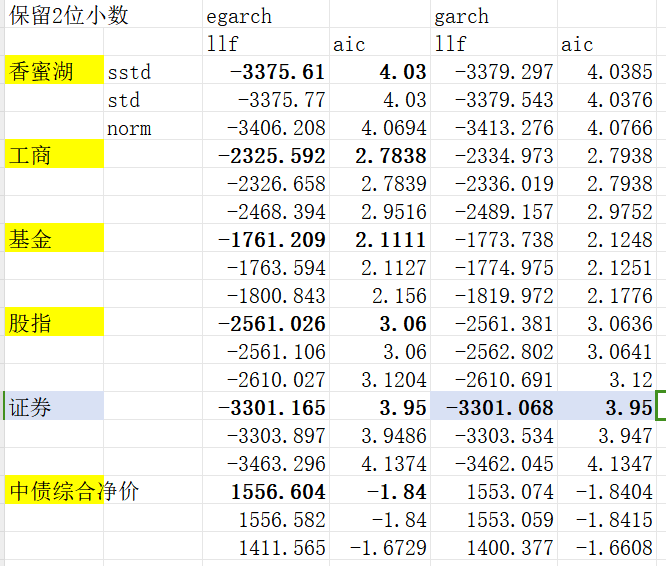

综合考虑最终选择了ARMA（1，2）-EGARCH（1，1）模型建立边缘分布。整理一下模型中参数估计表格。

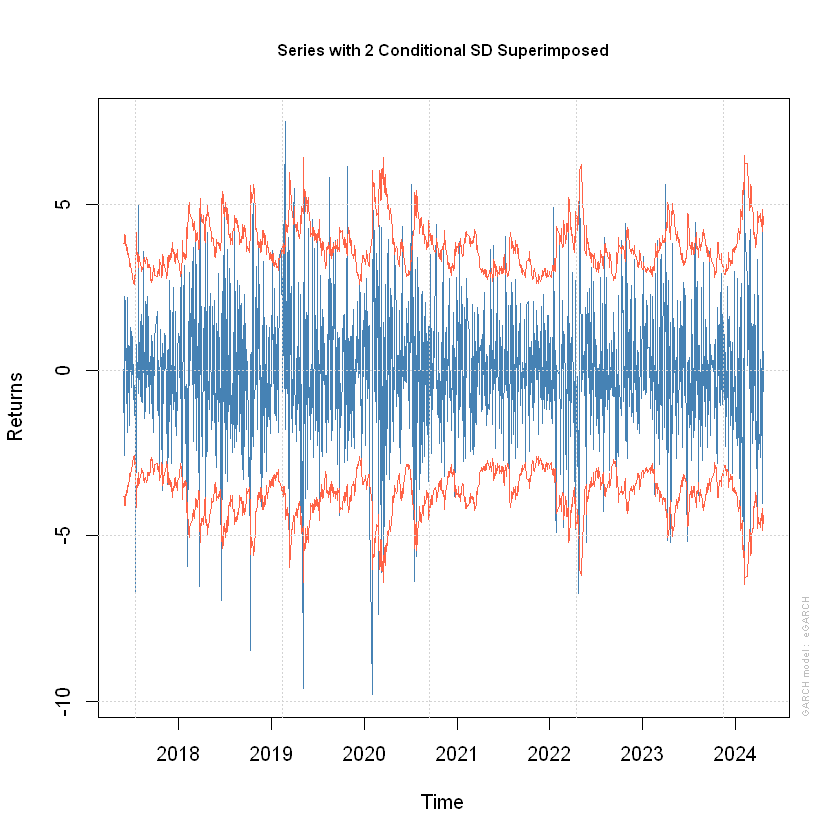

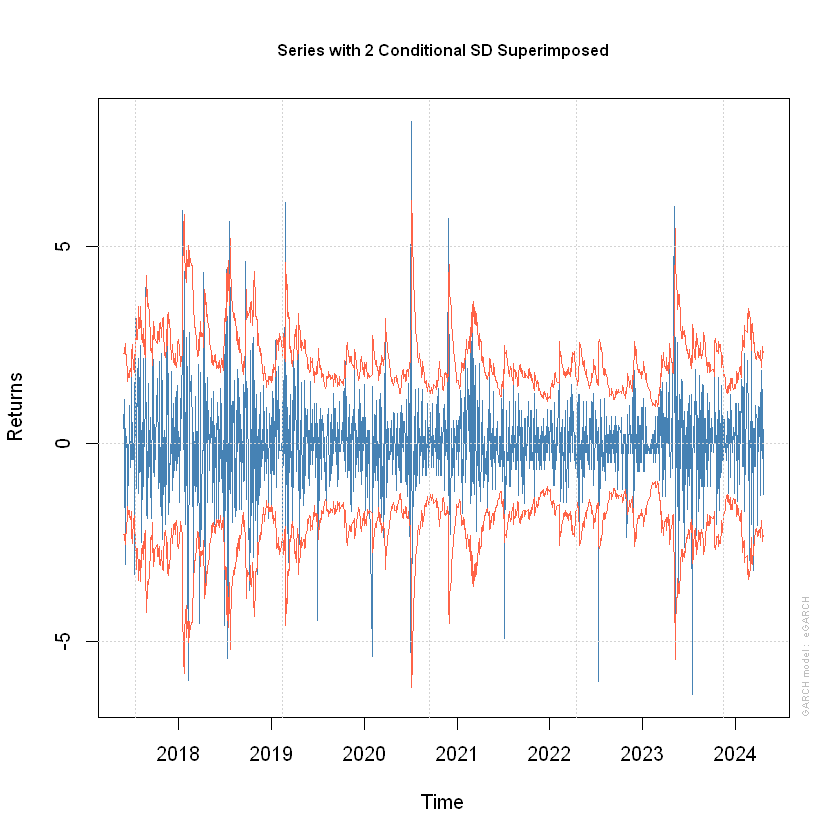

In [29]:
#模型拟合图像(可以都plot一下）)
plot(fit$香蜜湖指数,which=1)
plot(fit$工商银行,which=1)

提取模型残差 并进行LB检验 LM检验

In [25]:
#提取残差
fintech_res <- residuals(fit$香蜜湖指数)
index(fintech_res) <- date_st
bank_res <- residuals(fit$工商银行)
index(bank_res) <- date_st

fund_res <- residuals(fit$基金指数)
index(fund_res) <- date_st

stock_res <- residuals(fit$上证50)
index(stock_res) <- date_st

security_res <- residuals(fit$中信证券)
index(security_res) <- date_st

bond_res <- residuals(fit$中债国债总指数)
index(bond_res) <- date_st
#残差检验

In [ ]:
#残差标准化处理

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -0.783078 0.620528 
Weights: 0.302145 0.35876 0.339094 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 0.783078  1.267784  0.008009 -0.185725  1.155986  0.620528  1.587801 -0.169112 

Log-likelihood: -3403.292,  Average log-likelihood: -2.0282


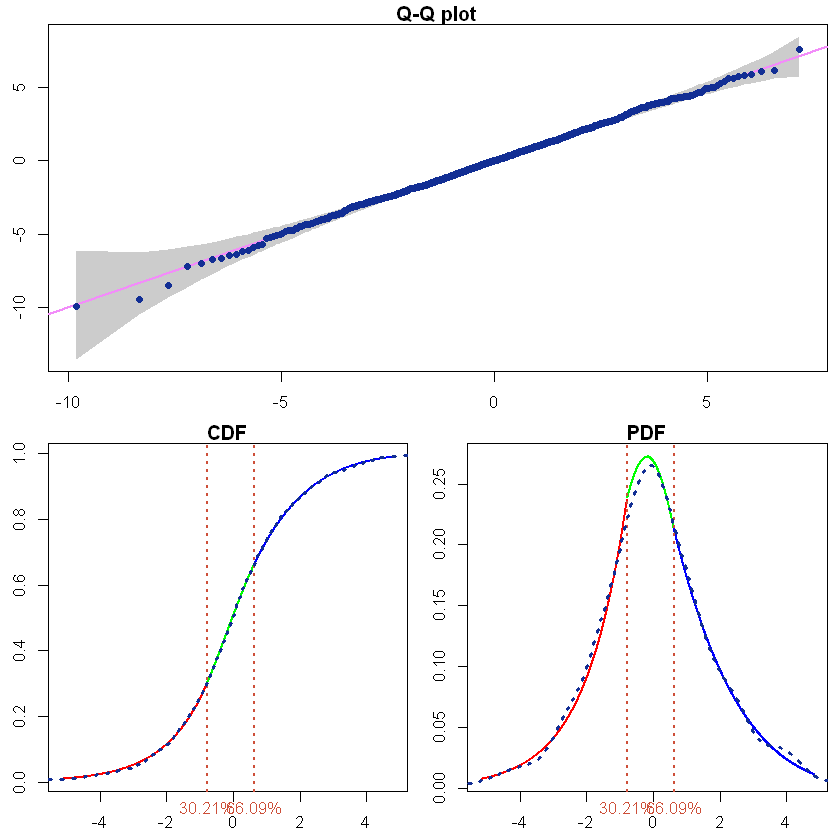

In [38]:
evt_fintech<-GNG_fit(fintech_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_fintech
plot(evt_fintech)

In [39]:
distribution(evt_fintech)

Composite distribution with: 
 
  Trafo       Distribution                                    Parameters Weight
1  -X   Generalized Pareto  loc = 0.7831, scale = 1.2678, shape = 0.008  0.3021
2 none        Normal                mean = -0.1857, sd = 1.156           0.3588
3 none  Generalized Pareto loc = 0.6205, scale = 1.5878, shape = -0.1691 0.3391
        Truncation
1  (-Inf,-0.7831) 
2 [-0.7831,0.6205)
3   [0.6205,Inf)  

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.602212 1.600255 
Weights: 0.056019 0.892729 0.051251 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.602212  0.880220  0.132821 -0.019846  0.791111  1.600255  0.886932  0.175203 

Log-likelihood: -2416.946,  Average log-likelihood: -1.4404


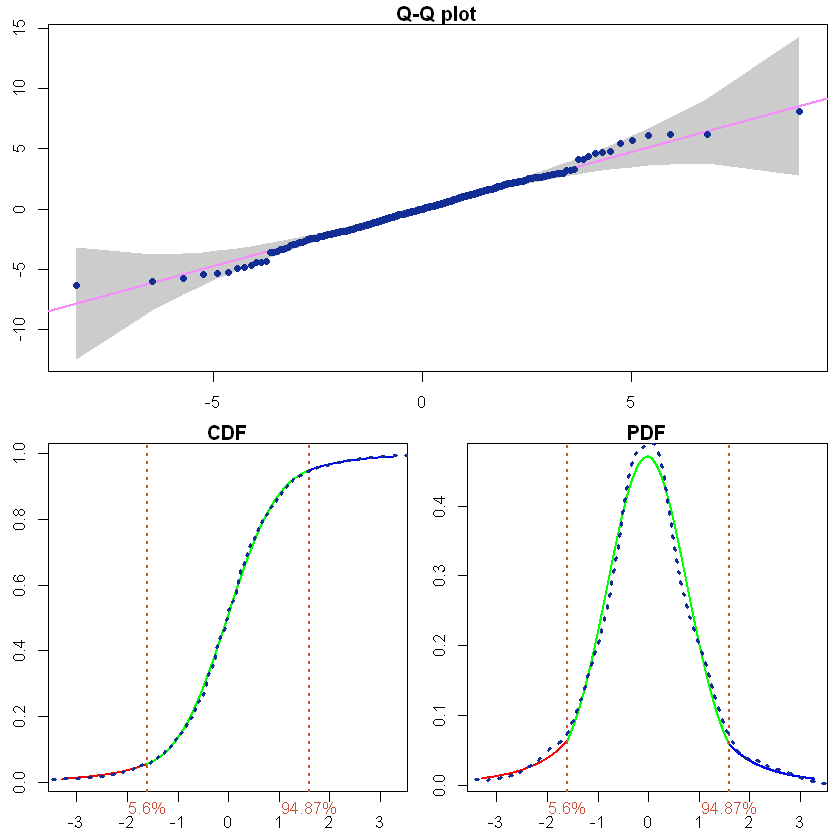

In [29]:
evt_bank <- GNG_fit(bank_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_bank
plot(evt_bank)

In [40]:
distribution(evt_bank)

Composite distribution with: 
 
  Trafo       Distribution                                   Parameters Weight
1  -X   Generalized Pareto loc = 1.6022, scale = 0.8802, shape = 0.1328 0.0560
2 none        Normal               mean = -0.0198, sd = 0.7911          0.8927
3 none  Generalized Pareto loc = 1.6003, scale = 0.8869, shape = 0.1752 0.0513
        Truncation
1  (-Inf,-1.6022) 
2 [-1.6022,1.6003)
3   [1.6003,Inf)  

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -2.007086 1.262643 
Weights: 0.007747 0.945173 0.04708 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 2.007086  1.180144 -0.222632 -0.004982  0.668543  1.262643  0.488479  0.229070 

Log-likelihood: -1879,  Average log-likelihood: -1.1198


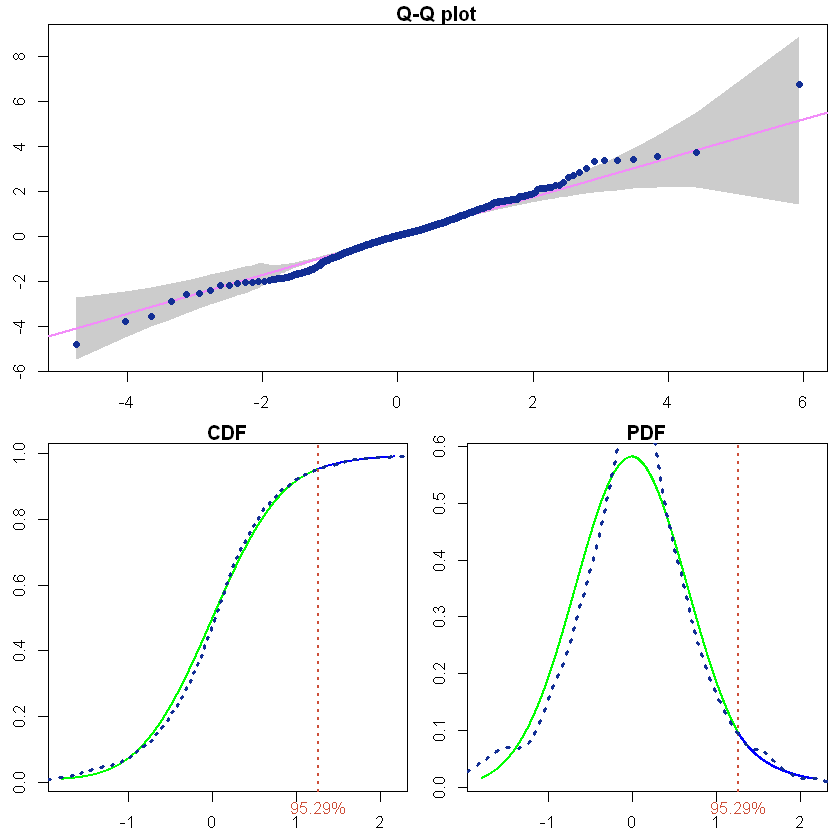

In [30]:
evt_fund <- GNG_fit(fund_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_fund
plot(evt_fund)

In [41]:
distribution(evt_fund)

Composite distribution with: 
 
  Trafo       Distribution                                    Parameters Weight
1  -X   Generalized Pareto loc = 2.0071, scale = 1.1801, shape = -0.2226 0.0077
2 none        Normal                mean = -0.005, sd = 0.6685           0.9452
3 none  Generalized Pareto loc = 1.2626, scale = 0.4885, shape = 0.2291  0.0471
        Truncation
1  (-Inf,-2.0071) 
2 [-2.0071,1.2626)
3   [1.2626,Inf)  

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.755599 1.545114 
Weights: 0.056615 0.860548 0.082837 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.755599  0.875020  0.037892  0.002704  0.918871  1.545114  0.839536 -0.023178 

Log-likelihood: -2603.473,  Average log-likelihood: -1.5515


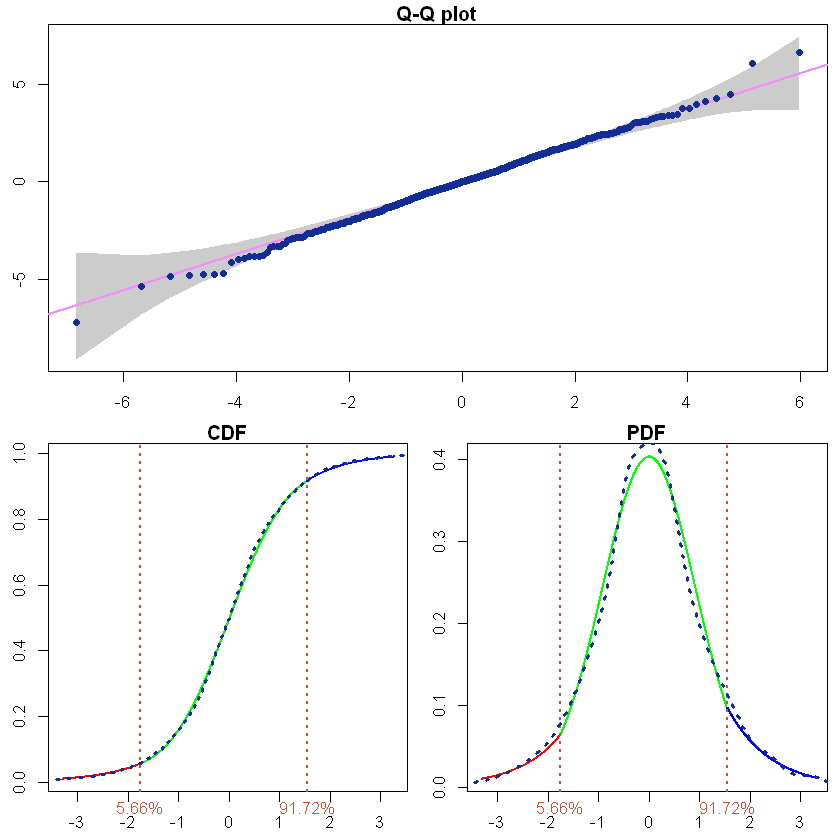

In [31]:
evt_stock <- GNG_fit(stock_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_stock
plot(evt_stock)

In [42]:
distribution(evt_stock)

Composite distribution with: 
 
  Trafo       Distribution                                    Parameters Weight
1  -X   Generalized Pareto  loc = 1.7556, scale = 0.875, shape = 0.0379  0.0566
2 none        Normal                mean = 0.0027, sd = 0.9189           0.8605
3 none  Generalized Pareto loc = 1.5451, scale = 0.8395, shape = -0.0232 0.0828
        Truncation
1  (-Inf,-1.7556) 
2 [-1.7556,1.5451)
3   [1.5451,Inf)  

In [36]:
#债市不行
evt_bond <- GNG_fit(bond_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_bond
plot(evt_bond)

ERROR: Error in GPDdist(-breakpoints[1], scale1, coe["shape1"]): scale must be positive.


Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.793529 1.538405 
Weights: 0.11919 0.728844 0.151967 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.793529  1.138911  0.153595 -0.106447  1.175158  1.538405  1.379989  0.159220 

Log-likelihood: -3328.913,  Average log-likelihood: -1.9839


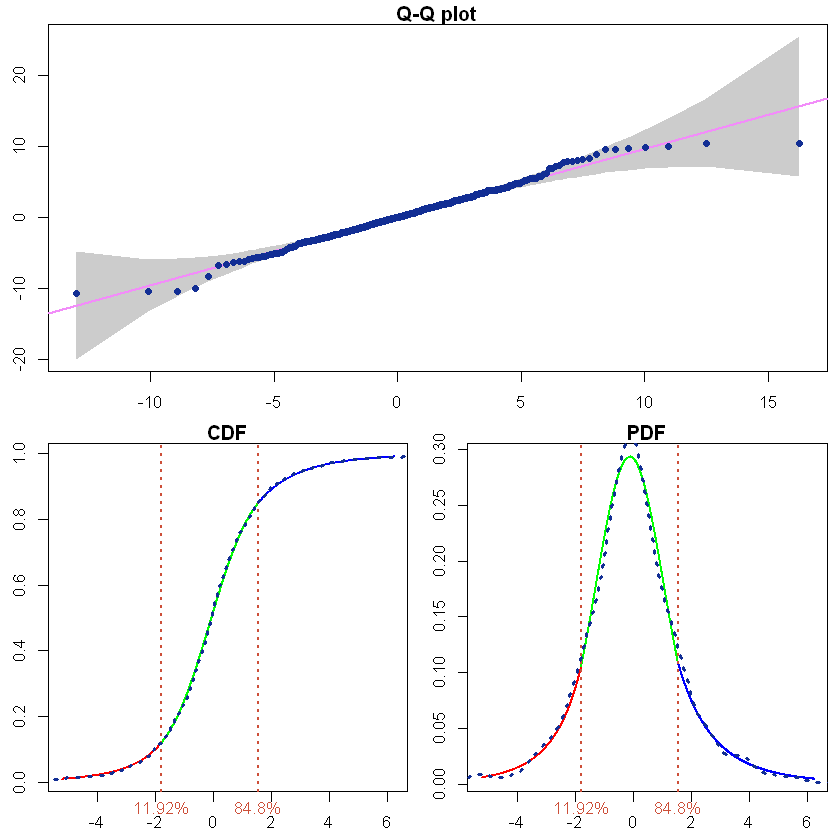

In [34]:
evt_security <- GNG_fit(security_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_security
plot(evt_security)

In [43]:
distribution(evt_security)

Composite distribution with: 
 
  Trafo       Distribution                                   Parameters Weight
1  -X   Generalized Pareto loc = 1.7935, scale = 1.1389, shape = 0.1536 0.1192
2 none        Normal               mean = -0.1064, sd = 1.1752          0.7288
3 none  Generalized Pareto  loc = 1.5384, scale = 1.38, shape = 0.1592  0.1520
        Truncation
1  (-Inf,-1.7935) 
2 [-1.7935,1.5384)
3   [1.5384,Inf)  